# Import

In [1]:
import sys

root_dir = '../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets, distributions

# Dataset

In [2]:
dataset = datasets.ML20m()
n_user = dataset.n_user
n_item = dataset.n_item
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=30)

# device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

# Evaluator

In [3]:
# k
ks = [5, 10, 50]

score_function_dict = {
    "Recall"      : evaluators.recall,
    "Unpopularity": evaluators.unpopularity,
    "Unpopularity2": evaluators.unpopularity2,
    "Unpopularity3": evaluators.unpopularity3,
    "F1-score"    : evaluators.f1_score,
    "F1-score2"    : evaluators.f1_score2,
    "F1-score3"    : evaluators.f1_score3
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)
# coverage = evaluators.CoverageEvaluator(test_set, ks)
# hubness = evaluators.HubnessEvaluator(test_set, ks)

# Sampler

In [4]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [5]:
# Hyperparameters
lr = 1e-3
n_dim = 30
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# No Training Result

In [6]:
knn = searches.NearestNeighborhood(model)
trainer.valid(knn, userwise)
re_no_training = trainer.valid_scores.copy()
display(re_no_training)

,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.022458,0.959943,9.667368,0.022393,0.034339,0.043352,0.004971,0.044873,0.959752,9.670457,0.044835,0.068819,0.086737,0.018525,0.221315,0.957926,9.652529,0.221505,0.301703,0.42046,0.196156


# Training

In [7]:
# only traing no validation
trainer.fit(n_batch, n_epoch)

# Result

## Base CML

In [8]:
knn = searches.NearestNeighborhood(model)

# Recall
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()
display(re_base)

,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.234358,0.553269,1.828773,0.00082,0.206326,0.335501,0.000907,0.439147,0.523007,1.817052,0.003313,0.390556,0.637646,0.005395,0.844641,0.723541,4.11784,0.115378,0.7669,1.346843,0.166071


## CML+MP

In [9]:
n_sample = 600
bias_li = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = distributions.Gamma()

In [10]:
re_mpcml_li = []
for bias in bias_li:
    print(f'bias={bias}')
    mp = searches.NoDistinctionMutualProximity(model, gamma, n_sample, bias)
    trainer.valid(mp, userwise)
    re = trainer.valid_scores.copy()
    display(re)
    re_mpcml_li.append(re)

bias=0.0


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.00652,0.973343,8.31093,0.023457,0.011561,0.012735,0.000787,0.015912,0.965914,8.433679,0.047511,0.027064,0.030699,0.003185,0.175308,0.925007,8.439683,0.230696,0.214148,0.312457,0.073878


bias=0.1


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.009178,0.966528,7.546775,0.021305,0.016148,0.017886,0.000956,0.02127,0.958335,7.773105,0.044148,0.0359,0.040936,0.003828,0.214265,0.912229,7.980583,0.221269,0.256489,0.379108,0.084449


bias=0.2


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.011221,0.961609,7.137404,0.019824,0.019615,0.021827,0.001074,0.026089,0.952211,7.359006,0.041524,0.043454,0.050018,0.004335,0.257921,0.899536,7.581078,0.211819,0.301913,0.45343,0.096615


bias=0.3


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.013128,0.957112,6.810259,0.018464,0.022791,0.025476,0.001149,0.031035,0.945993,7.006109,0.038989,0.051073,0.059289,0.004795,0.309609,0.885798,7.189882,0.201615,0.353623,0.540924,0.11077


bias=0.4


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.015261,0.95249,6.513645,0.017111,0.026248,0.029546,0.001236,0.037367,0.939317,6.671072,0.036331,0.060556,0.071082,0.005395,0.3719,0.870373,6.785639,0.190203,0.413088,0.645557,0.126705


bias=0.5


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.017911,0.946891,6.22592,0.015728,0.030396,0.034536,0.001329,0.045442,0.930859,6.329703,0.033432,0.072055,0.085888,0.00609,0.448483,0.852477,6.355296,0.177315,0.483194,0.77302,0.145164


bias=0.6


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.021585,0.940015,5.917581,0.014141,0.036044,0.041397,0.001441,0.056945,0.920407,5.959293,0.030074,0.087789,0.106723,0.006977,0.5394,0.83193,5.890026,0.16272,0.562308,0.922328,0.163723


bias=0.7


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.02713,0.930459,5.568286,0.012284,0.044131,0.051608,0.001613,0.075392,0.90488,5.52505,0.025987,0.111626,0.139521,0.008142,0.640507,0.808721,5.397429,0.147122,0.644364,1.084373,0.177693


bias=0.8


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.036867,0.915876,5.130661,0.009945,0.057674,0.069143,0.001819,0.109282,0.879268,4.959033,0.020582,0.150766,0.198088,0.009844,0.733979,0.784752,4.913656,0.132354,0.713213,1.226876,0.181334


bias=0.9


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.060726,0.884289,4.443737,0.006523,0.087718,0.11075,0.002112,0.181628,0.827389,4.09716,0.012938,0.228295,0.31677,0.01095,0.797976,0.762557,4.506249,0.121467,0.75287,1.312407,0.174357


bias=1.0


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.234351,0.553303,1.82882,0.00082,0.207064,0.335486,0.000907,0.439135,0.522992,1.817013,0.003313,0.390542,0.637627,0.005395,0.844641,0.723541,4.117838,0.115378,0.766899,1.346842,0.166071


In [11]:
re_recall = []
re_unpop1 = []
re_unpop2 = []
re_unpop3 = []
for re in re_mpcml_li:
    re_recall.append(re.iloc[-1, 7])
    re_unpop1.append(re.iloc[-1, 8])
    re_unpop2.append(re.iloc[-1, 9])
    re_unpop3.append(re.iloc[-1, 10])

## Recall vs Unpopularity1

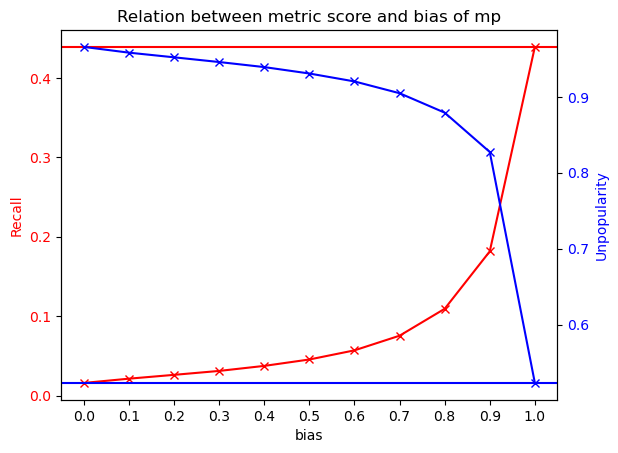

In [12]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop1, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 8], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 8], color='blue', linestyle='--')

# グラフの表示
plt.show()

## Recall vs Unpopularity2

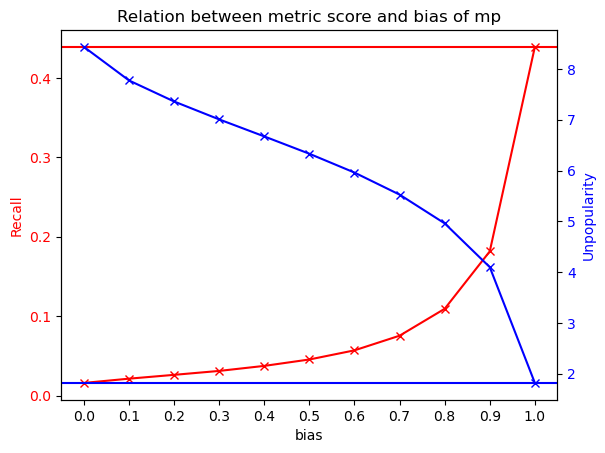

In [13]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop2, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 9], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 9], color='blue', linestyle='--')

# グラフの表示
plt.show()

## Recall vs Unpopularity3

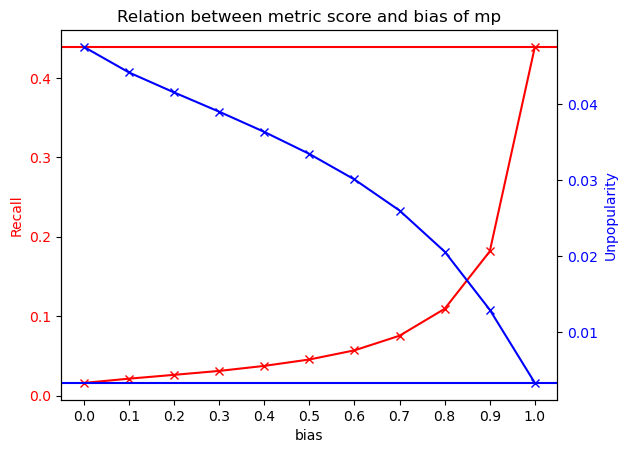

In [14]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop3, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 10], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 10], color='blue', linestyle='--')

# グラフの表示
plt.show()